# Thông tin đồ án:


- Chủ đề: Crowd Counting
- Lớp: CS117.N21.KHTN
- Giảng viên: TS. Ngô Đức Thành
- Sinh viên 1: Nguyễn Tuấn Anh - 21520142
- Sinh viên 2: Hà Văn Hoàng - 21520033
- Sinh viên 3: Phan Trường Trí - 21520117
- Sinh viên 4: Lương Toàn Bách - 21521845
- Sinh viên 5: Nguyễn Trường Thịnh - 21520110

# Chuẩn bị các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Chuẩn bị dữ liệu

In [ ]:
def show(im):
  plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
from sklearn.model_selection import train_test_split

train = pd.DataFrame([[p.path for p in os.scandir('Mall\\frames\\')], scipy.io.loadmat('Mall\\mall_gt.mat')['frame'][0]]).T.values.tolist()
for i in range(len(train)):
  train[i][1] = train[i][1][0][0][0]

train, valid = train_test_split(train, test_size=600, random_state=42)
valid, test = train_test_split(valid, test_size=300, random_state=42)

In [ ]:
aug_train = A.Compose([
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val_test = A.Compose([
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
  def __init__(self, data, aug):
    self.data = data
    self.aug = aug

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    fn = self.data[idx][0]
    ps = self.data[idx][1]

    im = cv2.imread(fn, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    rst = self.aug(image=im, keypoints=ps)
    im = rst['image']
    ps = rst['keypoints']

    dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
    for x, y in ps:
      x = int(x)
      y = int(y)
      dm[y, x] = 1

    sigma = 4
    dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
    dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
    dm *= 16

    im = torch.from_numpy(im)
    dm = torch.from_numpy(dm)

    return im, dm

# Dựng mô hình MCNN

In [ ]:
class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
    super(Conv2d, self).__init__()
    padding = int((kernel_size - 1) / 2) if same_padding else 0
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
    self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
    self.relu = nn.ReLU(inplace=True) if relu else None

  def forward(self, x):
    x = self.conv(x)
    if self.bn is not None:
      x = self.bn(x)
    if self.relu is not None:
      x = self.relu(x)
    return x

In [ ]:
class MCNN(LightningModule):
  '''
  Multi-column CNN
  -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
  '''

  def __init__(self, lr, max_steps, bn=False):
    super(MCNN, self).__init__()

    self.lr = lr
    self.save_hyperparameters()

    self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                  Conv2d(16,  8, 7, same_padding=True, bn=bn))

    self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                  Conv2d(20, 10, 5, same_padding=True, bn=bn))

    self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                  Conv2d(24, 12, 3, same_padding=True, bn=bn))

    self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
    self.crit = nn.MSELoss()

  def forward(self, im_data):
    im_data = im_data.unsqueeze(1)
    x1 = self.branch1(im_data)
    x2 = self.branch2(im_data)
    x3 = self.branch3(im_data)
    x = torch.cat((x1,x2,x3),1)
    x = self.fuse(x)

    return x.squeeze(1)


  def training_step(self, batch, batch_idx):
    self.train()
    x, y = batch

    pred = self(x)
    loss = self.crit(pred, y)

    pred_sum = torch.round(pred.sum(dim=(1,2))).int()
    gt_sum = torch.round(y.sum(dim=(1,2))).int()

    mae = torch.abs(pred_sum - gt_sum).float().mean()
    mse = torch.pow(pred_sum - gt_sum, 2).float().mean()

    self.log('train_mae', mae)
    self.log('train_mse', mse)

    return loss

  def validation_step(self, batch, batch_idx):
    with torch.no_grad():
      self.eval()
      x, y = batch

      pred = self(x)
      pred_sum = torch.round(pred.sum(dim=(1,2))).int()
      gt_sum = torch.round(y.sum(dim=(1,2))).int()

      mae = torch.abs(pred_sum - gt_sum).float().mean()
      mse = torch.pow(pred_sum - gt_sum, 2).float().mean()

      self.log('val_mae', mae)
      self.log('val_mse', mse)

  def test_step(self, batch, batch_idx):
    with torch.no_grad():
      self.eval()
      x, y = batch

      pred = self(x)
      pred_sum = torch.round(pred.sum(dim=(1,2))).int()
      gt_sum = torch.round(y.sum(dim=(1,2))).int()

      mae = torch.abs(pred_sum - gt_sum).float().mean()
      mse = ((pred_sum - gt_sum)**2).float().mean()

      self.log('test_mae', mae)
      self.log('test_mse', mse)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    scheduler = {
      'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
      'interval': 'step',
      'frequency': 1
    }

    return [optimizer], [scheduler]

In [ ]:
def weights_normal_init(model, dev=0.01):
  if isinstance(model, list):
    for m in model:
      weights_normal_init(m, dev)
  else:
    for n, m in model.named_modules():
      if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, dev)
        if m.bias is not None:
          m.bias.data.fill_(0.0)
      elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0, dev)

# Training - Testing

In [ ]:
seed_everything(42)
lr = 3e-4

Global seed set to 42


In [ ]:
checkpoint = ModelCheckpoint(
  save_top_k = 1,
  save_last = True,
  verbose = True,
  monitor = 'val_mae',
  mode = 'min',
)

train_data = MyDataset(train, aug_train)
val_data = MyDataset(valid, aug_val_test)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, drop_last=False, pin_memory=True)

max_steps = (len(train) // 8) * 15
trainer = Trainer(accelerator='gpu', devices=1, max_steps=max_steps, precision="16-mixed", benchmark=True, callbacks=[checkpoint, LearningRateMonitor()])

model = MCNN(lr, max_steps=max_steps)
weights_normal_init(model, dev=0.01)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | branch1 | Sequential | 57.8 K
1 | branch2 | Sequential | 46.1 K
2 | branch3 | Sequential | 24.0 K
3 | fuse    | Sequential | 31    
4 | crit    | MSELoss    | 0     
---------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.512     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 175/175 [03:23<00:00,  1.17s/it, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 175/175 [03:40<00:00,  1.26s/it, v_num=2]     

Epoch 0, global step 175: 'val_mae' reached 9.40667 (best 9.40667), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_2\\checkpoints\\epoch=0-step=175.ckpt' as top 1


Epoch 1: 100%|██████████| 175/175 [02:42<00:00,  1.08it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 175/175 [02:52<00:00,  1.02it/s, v_num=2]     

Epoch 1, global step 350: 'val_mae' was not in top 1


Epoch 2: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 175/175 [02:52<00:00,  1.01it/s, v_num=2]     

Epoch 2, global step 525: 'val_mae' reached 3.32000 (best 3.32000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_2\\checkpoints\\epoch=2-step=525.ckpt' as top 1


Epoch 3: 100%|██████████| 175/175 [03:24<00:00,  1.17s/it, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 175/175 [03:34<00:00,  1.22s/it, v_num=2]     

Epoch 3, global step 700: 'val_mae' was not in top 1


Epoch 4: 100%|██████████| 175/175 [02:42<00:00,  1.08it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 175/175 [02:52<00:00,  1.02it/s, v_num=2]     

Epoch 4, global step 875: 'val_mae' was not in top 1


Epoch 5: 100%|██████████| 175/175 [02:42<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 175/175 [02:52<00:00,  1.02it/s, v_num=2]     

Epoch 5, global step 1050: 'val_mae' was not in top 1


Epoch 6: 100%|██████████| 175/175 [02:42<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 175/175 [02:52<00:00,  1.01it/s, v_num=2]     

Epoch 6, global step 1225: 'val_mae' reached 3.17667 (best 3.17667), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_2\\checkpoints\\epoch=6-step=1225.ckpt' as top 1


Epoch 7: 100%|██████████| 175/175 [02:44<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 175/175 [02:53<00:00,  1.01it/s, v_num=2]     

Epoch 7, global step 1400: 'val_mae' reached 1.95667 (best 1.95667), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_2\\checkpoints\\epoch=7-step=1400.ckpt' as top 1


Epoch 8: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 175/175 [02:53<00:00,  1.01it/s, v_num=2]     

Epoch 8, global step 1575: 'val_mae' was not in top 1


Epoch 9: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 175/175 [02:52<00:00,  1.01it/s, v_num=2]     

Epoch 9, global step 1750: 'val_mae' was not in top 1


Epoch 10: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 175/175 [02:53<00:00,  1.01it/s, v_num=2]    

Epoch 10, global step 1925: 'val_mae' was not in top 1


Epoch 11: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 175/175 [02:53<00:00,  1.01it/s, v_num=2]    

Epoch 11, global step 2100: 'val_mae' was not in top 1


Epoch 12: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 175/175 [02:52<00:00,  1.01it/s, v_num=2]    

Epoch 12, global step 2275: 'val_mae' was not in top 1


Epoch 13: 100%|██████████| 175/175 [02:43<00:00,  1.07it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 175/175 [02:52<00:00,  1.01it/s, v_num=2]    

Epoch 13, global step 2450: 'val_mae' was not in top 1


Epoch 14: 100%|██████████| 175/175 [02:42<00:00,  1.08it/s, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 175/175 [02:52<00:00,  1.02it/s, v_num=2]    

Epoch 14, global step 2625: 'val_mae' was not in top 1
`Trainer.fit` stopped: `max_steps=2625` reached.


Epoch 14: 100%|██████████| 175/175 [02:52<00:00,  1.02it/s, v_num=2]


In [ ]:
test_loader = DataLoader(MyDataset(test, aug_val_test), batch_size=8, shuffle=False, drop_last=False, pin_memory=True)
trainer.test(dataloaders = test_loader)

C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\havan\MCNN\lightning_logs\version_2\checkpoints\epoch=7-step=1400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\havan\MCNN\lightning_logs\version_2\checkpoints\epoch=7-step=1400.ckpt
C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the num

Testing DataLoader 0: 100%|██████████| 38/38 [00:09<00:00,  4.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            2.0866665840148926
        test_mse             6.986666679382324
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 2.0866665840148926, 'test_mse': 6.986666679382324}]

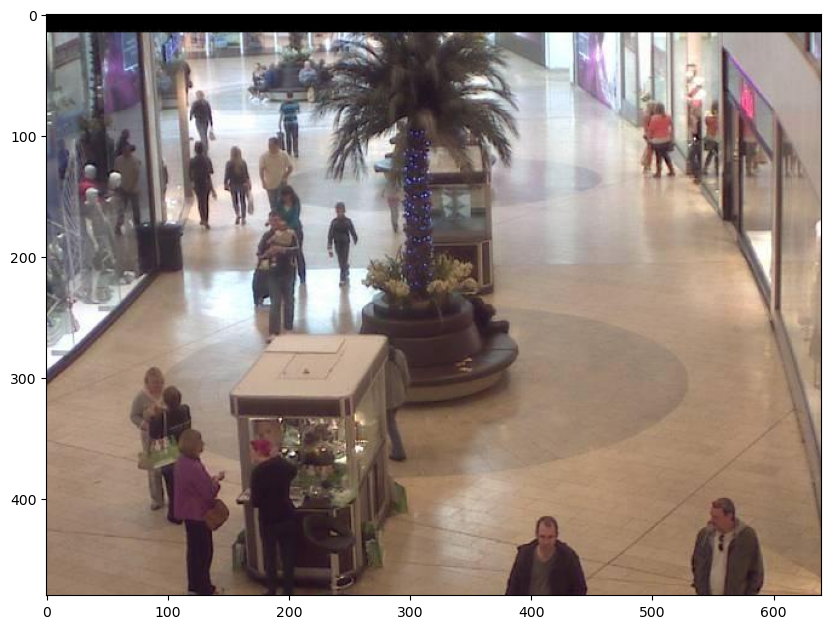

In [ ]:
ds = MyDataset(test, aug_val_test)
im, dm = ds[86]
show(cv2.imread(test[86][0], cv2.IMREAD_COLOR))

25

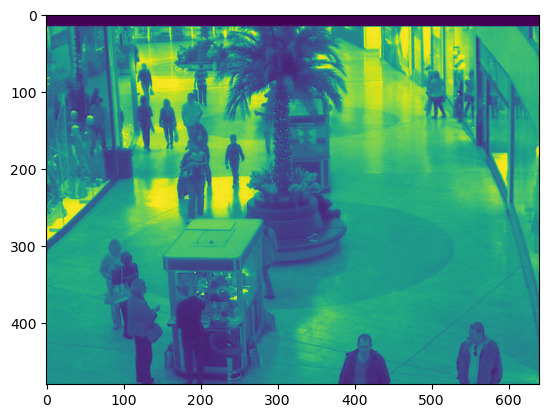

In [ ]:
plt.imshow(im)
ps = test[86][1]
len(ps)

tensor(25.)

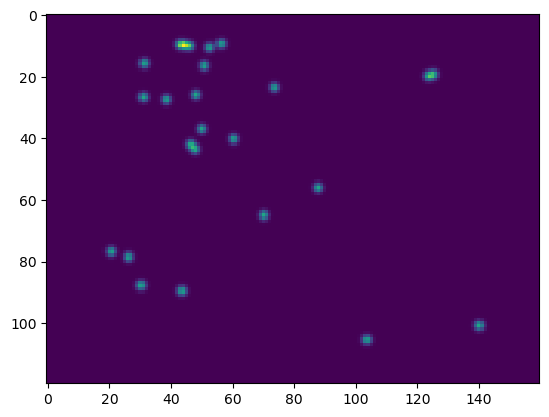

In [ ]:
plt.imshow(dm)
dm.sum()

tensor(25.)

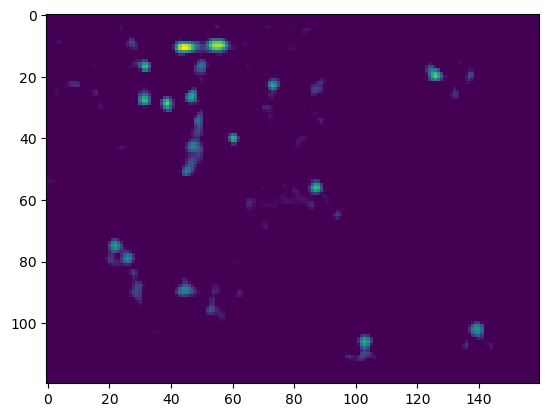

In [ ]:
plt.imshow(model(im.unsqueeze(0)).detach()[0])
torch.round(model(im.unsqueeze(0)).detach()[0].sum())